# Preprocessing Human Annotation

This script processes human annotation data for further analysis and evaluation. It performs the following steps:

## Data Retrieval and Processing
The data from the database is retrieved and converted into dataframes.

### Descriptive Statistics
The following descriptive statistics are computed to better understand the distribution of annotations:
- **Mean**
- **Median**
- **Mode**
- **Interquartile Range (IQR)**
- **Standard Deviation**

Additionally, **boxplots** are generated to visualize the spread of annotations across raters.

### Agreement Measures
To assess the reliability of the annotations, the following agreement measures are computed:
- **Intraclass Correlation Coefficient (ICC)**
- **Kendall’s Tau**

### Data Aggregation
To facilitate further comparison, the annotations from multiple raters are aggregated using the **mean**.

### Qualitative Evaluation
For a qualitative evaluation, the data is filtered for data points with the most discrepancies across raters.


Install and load required libraries.

In [ ]:
!pip install pingouin -q
!pip install pymongo -q
!pip install python-dotenv -q
!pip install krippendorff -q
!pip install --upgrade pandas -q
#!pip install --upgrade seaborn -q
#!pip install pandas==1.5.3 -q

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import mode, stats
from pingouin import intraclass_corr
from pymongo import MongoClient
from dotenv import load_dotenv
import os
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import krippendorff

In [5]:
print(pd.__version__)  # required: 2.2.3 !

2.2.3


### Set up MongoDB connection

In [6]:
load_dotenv()  # load gitignore

mongo_user = os.getenv("MONGO_USER")
mongo_password = os.getenv("MONGO_PASSWORD")
cluster_url = os.getenv("MONGO_CLUSTER_URL")
gradio_user = os.getenv("GRADIO_USER")
gradio_password = os.getenv("GRADIO_PASSWORD")

In [7]:
connection_url = f"mongodb+srv://{mongo_user}:{mongo_password}@{cluster_url}"
client = MongoClient(connection_url)
db = client["thesis"]
collection = db["labeling"]

Retrieve labeled data given annotator names.

In [8]:
def get_df(annotators):
    pipeline = [
        {"$match": {"ratings.rater": {"$in": list(annotators)}}},
        {"$unwind": "$ratings"},
        {"$match": {"ratings.rater": {"$in": list(annotators)}}},
        {
            "$project": {
                "id": "$meta_information.id",
                "turn": "$meta_information.turn",
                "rater": "$ratings.rater",
                "alignment": "$ratings.alignment",
                "quality": "$ratings.quality",
                "consistency": "$ratings.consistency",
                "overall": "$ratings.overall",
            }
        },
    ]

    data = list(collection.aggregate(pipeline))
    return pd.DataFrame(data)

In [9]:
# specify the raters to determine which entries should be included in the dataframe
# Canva's raters: "ej", "renz", "basil", "Thomas", "sona"

df_3 = get_df({"ej", "renz", "basil"})
# df_4 = get_df({"ej", "renz", "basil", "pia"})
# df_5 = get_df({"ej", "renz", "basil", "Thomas", "sona"})

In [10]:
# load own annotations of extreme cases
pia = pd.read_csv("human_scores.csv", sep=";")

pia = pia.drop(
    [
        "human_rating_binary",
        "human_alignment_binary",
        "human_aesthetics_binary",
        "human_consistency_binary",
    ],
    axis=1,
)

pia = pia.rename(
    columns={
        "human_rating_multi": "overall",
        "human_alignment_multi": "alignment",
        "human_aesthetics_multi": "quality",
        "human_consistency_multi": "consistency",
    }
)

In [11]:
# combine trained raters' annotations with own
def combine_df_with_mine(df, rater):
    pia["rater"] = "pia"
    df = pd.concat([df, pia], ignore_index=True)

    rater_count = df.groupby(["id", "turn"])["rater"].nunique().reset_index()
    complete_cases = rater_count[rater_count["rater"] == len(rater)][["id", "turn"]]

    df = df.merge(complete_cases, on=["id", "turn"])
    return df

In [12]:
rater = {"renz", "ej", "basil", "pia"}
df_all = combine_df_with_mine(df_3, rater)

In [9]:
# df.to_csv("thesis_annotations_thomas.csv")

## Analyze Annotations

Check how many data points have been labeled by the same people.

In [4]:
df = pd.read_csv("annotations/annotations_02_25.csv")
df = df.drop(columns=["Unnamed: 0"], axis=1)

In [5]:
# filter df for only ratings of data points which were labeled by all raters
def filter_complete_ratings(df, raters):
    df_filtered = df[df["rater"].isin(raters)]
    rater_counts = df_filtered.groupby("_id")["rater"].nunique()
    valid_ids = rater_counts[rater_counts == len(raters)].index
    df_valid = df_filtered[df_filtered["_id"].isin(valid_ids)]
    return df_valid

In [6]:
raters = ["renz", "ej", "basil"]
df = filter_complete_ratings(df, raters)
df.head()

,_id,rater,alignment,quality,consistency,overall
1,677d856e8640497613a5ea32,renz,1,10,10,1
2,677d856e8640497613a5ea32,ej,1,10,10,2
3,677d856e8640497613a5ea32,basil,0,10,10,0
5,677d856e8640497613a5ea35,ej,8,8,9,8
6,677d856e8640497613a5ea35,basil,10,7,8,8


In [7]:
# given a group of raters, get the amount of data points labeled by everyone
def get_annotation_sum(group):
    common_ids = (
        df[df["rater"].isin(group)]
        .groupby("_id")["rater"]
        .unique()
        .apply(lambda x: set(x) == group)
    )

    num_common_ids = common_ids.sum()
    return num_common_ids

In [8]:
group_5 = {"basil", "renz", "ej", "Thomas", "sona"}
group_4 = {"basil", "renz", "ej", "Thomas"}
group_3 = {"basil", "renz", "ej"}

# print(f"5 annotators: {get_annotation_sum(group_5)}")
# print(f"4 annotators: {get_annotation_sum(group_4)}")
print(f"3 annotators: {get_annotation_sum(group_3)}")

3 annotators: 474


## Descriptive Statistics
- Central Tendency & Spread: mean, median, mode, sd/var, IQR scores for each aspect
- Visualizations: boxplots / histogram

In [9]:
aspects = ["alignment", "quality", "consistency", "overall"]

In [10]:
def get_stats(df):
    stats = {}

    for aspect in aspects:
        mean_val = df[aspect].mean()
        median_val = df[aspect].median()
        mode_result = mode(df[aspect], nan_policy="omit")
        mode_val = (
            np.atleast_1d(mode_result.mode)[0] if mode_result.count.size > 0 else np.nan
        )
        std_dev = df[aspect].std()
        iqr_val = df[aspect].quantile(0.75) - df[aspect].quantile(0.25)

        stats[aspect] = {
            "Mean": mean_val,
            "Median": median_val,
            "Mode": mode_val,
            "Standard Deviation": std_dev,
            "IQR": iqr_val,
        }

    print("Ratings per aspect")
    for aspect, values in stats.items():
        print(f"\n{aspect}")
        for key, val in values.items():
            print(f"{key}: {val:.3f}")

In [11]:
get_stats(df)  # 3 rater

Ratings per aspect

alignment
Mean: 8.160
Median: 10.000
Mode: 10.000
Standard Deviation: 3.093
IQR: 2.000

quality
Mean: 7.897
Median: 9.000
Mode: 10.000
Standard Deviation: 2.546
IQR: 3.000

consistency
Mean: 8.541
Median: 10.000
Mode: 10.000
Standard Deviation: 2.295
IQR: 2.000

overall
Mean: 7.419
Median: 9.000
Mode: 10.000
Standard Deviation: 2.935
IQR: 4.000


Boxplot of all ratings summed up (not averaged!).

/opt/conda/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


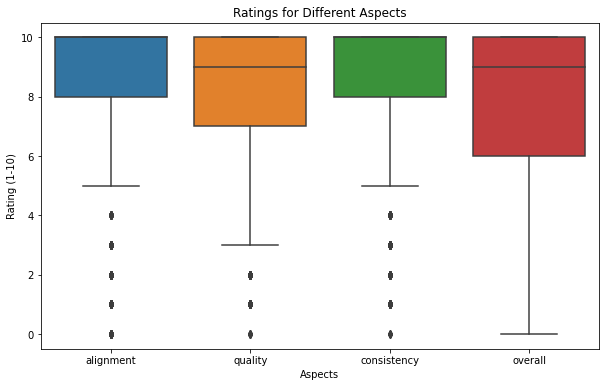

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[aspects])
plt.xlabel("Aspects")
plt.ylabel("Rating (1-10)")
plt.title("Ratings for Different Aspects")
plt.show()

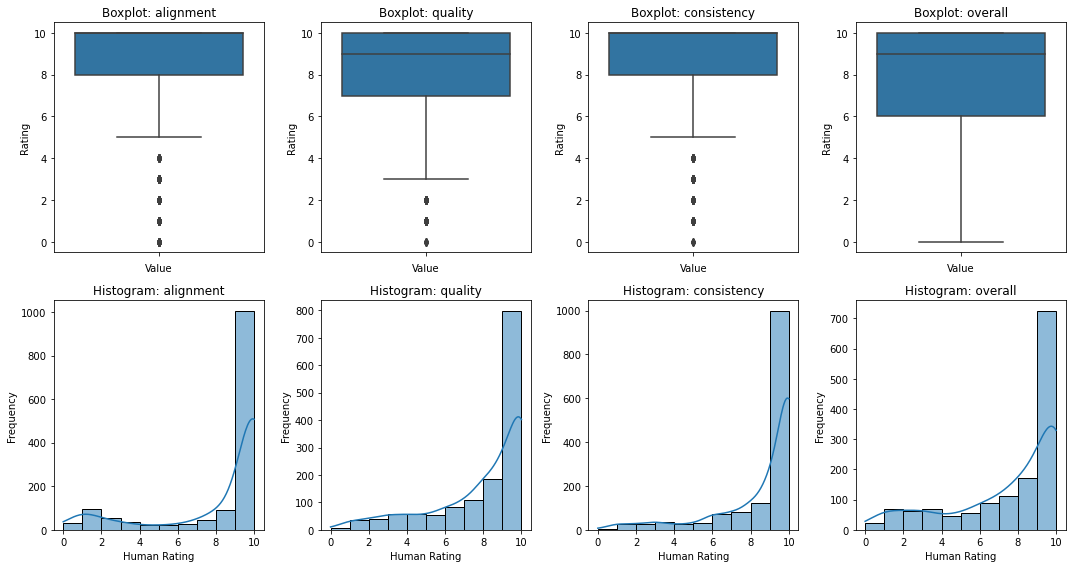

In [13]:
fig, axes = plt.subplots(2, len(aspects), figsize=(15, 8), sharey=False)

for i, aspect in enumerate(aspects):
    sns.boxplot(y=df[aspect], ax=axes[0, i])
    axes[0, i].set_title(f"Boxplot: {aspect}")
    axes[0, i].set_xlabel("Value")
    axes[0, i].set_ylabel("Rating")

for i, aspect in enumerate(aspects):
    sns.histplot(df[aspect], bins=10, kde=True, ax=axes[1, i])
    axes[1, i].set_title(f"Histogram: {aspect}")
    axes[1, i].set_xlabel("Human Rating")
    axes[1, i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## Rater Agreement

- ICC evaluates the consistency of ratings on a continuous scale (e.g., ratings of quality, alignment, etc.) -> how much raters agree on the magnitude of their ratings
- Kendall's Tau measures how similarly two raters rank the items (i.e., their order of preferences or evaluations) -> regardless of the actual numerical values they assign
- (Krippendorff’s Alpha: like ICC, but more robust against NaN)

#### ICC Model Choice: 2-way random effects model ICC(2,1)

Why? 
- Fixed raters and fixed samples
- Both are not randomly selected (i.e., they are a fixed set you want to generalize to)
- interested in the consistency of ratings across raters for each sample

The (2,1) part refers to:
- 2: "Two-way" refers to having both raters and samples as the sources of variability.
- 1: "Single measure" indicates interest in the consistency of ratings from individual raters (not averaging them across raters)


In [83]:
def icc_for_aspect(aspect, df):
    icc_results = pg.intraclass_corr(
        data=df, targets="_id", raters="rater", ratings=aspect, nan_policy="omit"
    )
    icc_value = icc_results[icc_results["Type"] == "ICC2"]["ICC"].values[0]
    print(f"ICC (2-way random effects) for {aspect}: {icc_value:.3f}")

In [14]:
# for basil, ej, renz
icc_for_aspect("alignment", df)
icc_for_aspect("quality", df)
icc_for_aspect("consistency", df)
icc_for_aspect("overall", df)

ICC (2-way random effects) for alignment: 0.725
ICC (2-way random effects) for quality: 0.509
ICC (2-way random effects) for consistency: 0.380
ICC (2-way random effects) for overall: 0.656


In [132]:
# for basil, ej, renz, pia
icc_for_aspect("alignment", df)
icc_for_aspect("quality", df)
icc_for_aspect("consistency", df)
icc_for_aspect("overall", df)

ICC (2-way random effects) for alignment: 0.817
ICC (2-way random effects) for quality: 0.615
ICC (2-way random effects) for consistency: 0.458
ICC (2-way random effects) for overall: 0.773


#### Kendall's Tau

In [94]:
df_all["_id"] = df_all.groupby(["id", "turn"])["_id"].transform(
    lambda x: x.ffill().bfill()
)

In [95]:
kendall_tau_results = {}

for aspect in aspects:
    df_pivot = df_all.pivot(index="_id", columns="rater", values=aspect)
    kendall_tau_matrix = df_pivot.corr(method="kendall")
    kendall_tau_results[aspect] = kendall_tau_matrix

for aspect, tau_matrix in kendall_tau_results.items():
    print(f"Kendall's Tau for {aspect}:\n{tau_matrix}\n")

Kendall's Tau for alignment:
rater     Thomas     basil        ej       pia      renz      sona
rater                                                             
Thomas  1.000000  0.535408  0.734688  0.722843  0.604188  0.620450
basil   0.535408  1.000000  0.589565  0.485390  0.514851  0.546718
ej      0.734688  0.589565  1.000000  0.701569  0.725962  0.698690
pia     0.722843  0.485390  0.701569  1.000000  0.642776  0.581909
renz    0.604188  0.514851  0.725962  0.642776  1.000000  0.596264
sona    0.620450  0.546718  0.698690  0.581909  0.596264  1.000000

Kendall's Tau for quality:
rater     Thomas     basil        ej       pia      renz      sona
rater                                                             
Thomas  1.000000  0.345444  0.517771  0.312782  0.171765  0.654640
basil   0.345444  1.000000  0.685130  0.154544  0.411387  0.482487
ej      0.517771  0.685130  1.000000  0.325012  0.467323  0.591539
pia     0.312782  0.154544  0.325012  1.000000  0.097782  0.383479
renz 

## Aggregation
Since there are only 3 annotators, computing the mean as the representative value is the most sensible approach (as it is very unlikely to have a median or majority for only 3 annotations).

In [14]:
def aggregate(df, raters):
    df_aggregated = df[df["rater"].isin(raters)]
    df_aggregated = (
        df_aggregated.groupby("_id")
        .agg(
            {
                "alignment": "mean",
                "quality": "mean",
                "consistency": "mean",
                "overall": "mean",
                #'_id': 'first',
                #'turn': 'first'
            }
        )
        .reset_index()
    )

    return df_aggregated.round(3)

In [16]:
df_all_aggregated = aggregate(df, {"renz", "ej", "basil"})
df_all_aggregated.head()
# df_aggregated.to_csv("annotations_mean_3.csv", index=False)

,_id,alignment,quality,consistency,overall
0,677d856e8640497613a5ea07,7.000,8.667,9.000,7.333
1,677d856e8640497613a5ea08,10.000,9.333,9.667,9.667
2,677d856e8640497613a5ea09,6.667,8.000,8.333,7.000
3,677d856e8640497613a5ea0a,7.000,4.333,6.333,4.667
4,677d856e8640497613a5ea0b,10.000,6.333,7.000,7.333


In [12]:
# df_aggregated = aggregate(df_4, {"renz", "ej", "basil", "pia"})
# df_aggregated.to_csv("annotations_mean_4_middle.csv", index=False)

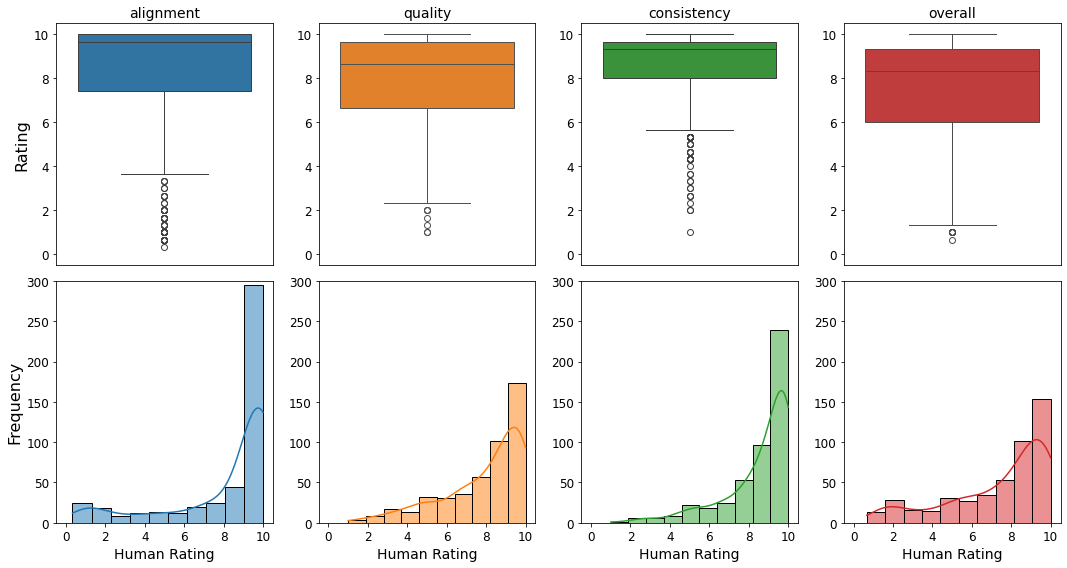

In [71]:
# same plot as above, but now with average values instead of summing all,
# and incorporating colors

colors = sns.color_palette()
fig, axes = plt.subplots(2, len(aspects), figsize=(15, 8), sharey=False)

rating_limits = (-0.5, 10.5)
frequency_limits = (0, 300)

for i, aspect in enumerate(aspects):
    sns.boxplot(y=df_aggregated[aspect], ax=axes[0, i], color=colors[i])
    axes[0, i].set_title(f"{aspect}", fontsize=14)
    (
        axes[0, i].set_ylabel("Rating", fontsize=16)
        if i == 0
        else axes[0, i].set_ylabel("")
    )
    axes[0, i].tick_params(axis="x", which="both", length=0)
    axes[0, i].set_ylim(rating_limits)
    axes[0, i].tick_params(axis="y", labelsize=12)

    axes[0, i].set_xticks([])

for i, aspect in enumerate(aspects):
    sns.histplot(
        df_aggregated[aspect], bins=10, kde=True, ax=axes[1, i], color=colors[i]
    )
    axes[1, i].set_xlabel("Human Rating", fontsize=14)
    (
        axes[1, i].set_ylabel("Frequency", fontsize=16)
        if i == 0
        else axes[1, i].set_ylabel("")
    )
    axes[1, i].set_xlim(rating_limits)
    axes[1, i].set_ylim(frequency_limits)
    axes[1, i].tick_params(axis="x", labelsize=12)
    axes[1, i].tick_params(axis="y", labelsize=12)

plt.tight_layout()
# plt.savefig("plots/mean_annotation_values.png", dpi=300, bbox_inches='tight')
plt.show()

### Qualitative Evaluation

For a qualitative examination of the datapoints, the data points with the highest discrepancies across raters are displayed.

In [19]:
# compute differences among raters
def get_differences(df, aspect):
    pivot_df = df.pivot(index=["_id"], columns="rater", values=aspect)
    # pivot_df = df.pivot(index=["id", "turn"], columns="rater", values=aspect)
    # compute difference for each data point
    pivot_df["max_diff"] = pivot_df.max(axis=1) - pivot_df.min(axis=1)
    return pivot_df[["max_diff"]].reset_index()


# compute biggest differences
alignment_diff = get_differences(df, "alignment")
quality_diff = get_differences(df, "quality")
consistency_diff = get_differences(df, "consistency")
overall_diff = get_differences(df, "overall")

# sort
alignment_diff_sorted = alignment_diff.sort_values(by="max_diff", ascending=False)
quality_diff_sorted = quality_diff.sort_values(by="max_diff", ascending=False)
consistency_diff_sorted = consistency_diff.sort_values(by="max_diff", ascending=False)
overall_diff_sorted = overall_diff.sort_values(by="max_diff", ascending=False)

print("Differences for alignment:")
print(alignment_diff_sorted.head(), "\n")

print("Differences for quality:")
print(quality_diff_sorted.head(), "\n")

print("Differences for consistency:")
print(consistency_diff_sorted.head(), "\n")

print("Differences for overall:")
print(overall_diff_sorted.head(), "\n")

Differences for alignment:
rater                       _id  max_diff
24     677d856e8640497613a5ea1f        10
272    677d856e8640497613a5eb2e         9
436    677d856e8640497613a5ebee         9
202    677d856e8640497613a5eae1         9
66     677d856e8640497613a5ea4c         9 

Differences for quality:
rater                       _id  max_diff
388    677d856e8640497613a5ebb3        10
355    677d856e8640497613a5eb8a        10
437    677d856e8640497613a5ebef        10
156    677d856e8640497613a5eaae         9
255    677d856e8640497613a5eb1b         9 

Differences for consistency:
rater                       _id  max_diff
388    677d856e8640497613a5ebb3        10
355    677d856e8640497613a5eb8a        10
52     677d856e8640497613a5ea3d         9
193    677d856e8640497613a5ead4         9
78     677d856e8640497613a5ea5a         9 

Differences for overall:
rater                       _id  max_diff
109    677d856e8640497613a5ea7e         9
272    677d856e8640497613a5eb2e         9
24    

In [17]:
# check exact ratings
df[(df["id"] == 493074) & (df["turn"] == 2)]

,_id,id,turn,rater,alignment,quality,consistency,overall
816,677d856e8640497613a5eb2e,493074,2,renz,1,10,10,1
817,677d856e8640497613a5eb2e,493074,2,ej,10,10,10,10
818,677d856e8640497613a5eb2e,493074,2,basil,10,8,10,9
